# AutoEncoder And GAN on MNIST

Here in this Jupyter Notebook I first pass the MNIST dataset through a simple AutoEncoder and then Pass the output images of autoencoder to GAN to generate new images based on them. 

## Importing the Required Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.layers import Input, Dense
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

%matplotlib inline

Using TensorFlow backend.


Here we import the MNIST dataset

In [2]:
(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

X_train = X_train.reshape(len(X_train), np.prod(X_train.shape[1:]))
X_test = X_test.reshape(len(X_test), np.prod(X_test.shape[1:]))
print(X_train.shape)
print(X_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 784)
(10000, 784)


## Declaring the autoencoder

In [3]:
input_img= Input(shape=(784,))

In [4]:
encoded = Dense(units=32, activation='relu')(input_img)

In [0]:
decoded = Dense(units=784, activation='sigmoid')(encoded)

In [0]:
autoencoder=Model(input_img, decoded)

In [7]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [9]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Training the encoder

In [10]:
autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 5s 78us/step - loss: 0.3574 - acc: 0.7560 - val_loss: 0.2713 - val_acc: 0.7959
Epoch 2/100
60000/60000 [==============================] - 4s 66us/step - loss: 0.2639 - acc: 0.7979 - val_loss: 0.2524 - val_acc: 0.7965
Epoch 3/100
60000/60000 [==============================] - 4s 66us/step - loss: 0.2413 - acc: 0.7975 - val_loss: 0.2282 - val_acc: 0.7955
Epoch 4/100
60000/60000 [==============================] - 4s 66us/step - loss: 0.2208 - acc: 0.7970 - val_loss: 0.2114 - val_acc: 0.7976
Epoch 5/100
60000/60000 [==============================] - 4s 68us/step - loss: 0.2067 - acc: 0.7981 - val_loss: 0.1994 - val_acc: 0.7986
Epoch 6/100
60000/60000 [==============================] - 4s 67us/step - loss: 0.1959 - acc: 0.7995 - val_loss: 0.1899 - val_acc: 0.7998
Epoch 7/100
60000/60000 [==============================] - 4s 67us/step - loss: 0.1874 - acc: 0.8007 - val_loss: 0.1821 -

In [0]:
predicted = autoencoder.predict(X_test)

## Viewing The results of encoder

Here the first row shows the original test images and the second row shows the result of autoencoder of same images

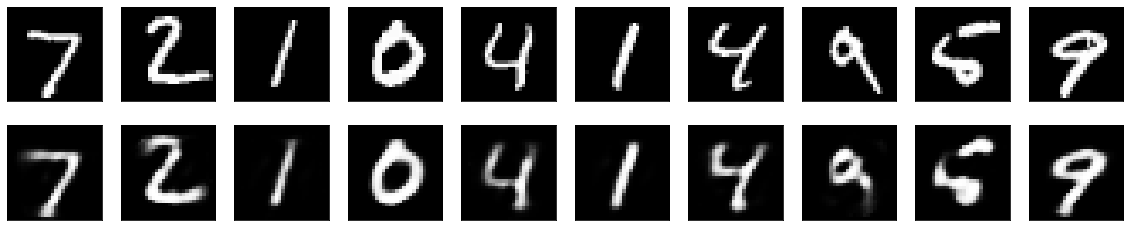

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predicted[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Creating the GAN

GANs have 2 networks one `generator` and another `discriminator`. Generator network produces the fake images from random noise using input data. And discriminator tries to classify images as fake and real. The main goal of generator is to output images so that discrimainator cannot predict whether the image is fake or real in which case an equilibrium is established.

In [0]:
np.random.seed(1000)
randomDim = 100

In [0]:
adam = Adam(lr=0.0002, beta_1=0.5)

### Creating the generator

Here we create a GAN generator which has 3 hidden dense layer and one final output layer. Each of the hidden layer uses `Leaky Rectified Linear Unit` or `LeakyReLU` as the activation function whereas the final output layer uses `hyperbolic-tangent` or `tanh` as the activation function.

In [0]:
generator = Sequential()
generator.add(Dense(256, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)

Next we create a GAN discriminator network. Here the discriminator network also consists of 3 hidden layers and one final output layer. Each of the hidden layer has LeakyReLu as the activation function. Whereas the final output layer has `sigmoid` as the activation function as we are required to output a probability of an image being real or fake.

In [17]:
discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

In [0]:
dLosses = []
gLosses = []

In [0]:
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

In [0]:
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()

Defining the train function for GAN

In [0]:
def train(epochs=1, batchSize=128):
    batchCount = int(predicted.shape[0] / batchSize)
    print('Epochs:', epochs)
    print('Batch size:', batchSize)
    print('Batches per epoch:', batchCount)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batchCount)):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, predicted.shape[0], size=batchSize)]

            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            # print np.shape(imageBatch), np.shape(generatedImages)
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)


    # Plot losses from every epoch
    plotLoss(e)

### Training the GAN and viewing results

  0%|          | 0/78 [00:00<?, ?it/s]

Epochs: 400
Batch size: 128
Batches per epoch: 78
--------------- Epoch 1 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.16it/s]

--------------- Epoch 2 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.09it/s]

--------------- Epoch 3 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.18it/s]

--------------- Epoch 4 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.08it/s]

--------------- Epoch 5 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.94it/s]

--------------- Epoch 6 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.73it/s]

--------------- Epoch 7 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.30it/s]

--------------- Epoch 8 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.36it/s]

--------------- Epoch 9 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.14it/s]

--------------- Epoch 10 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.01it/s]

--------------- Epoch 11 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.94it/s]

--------------- Epoch 12 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.81it/s]

--------------- Epoch 13 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.22it/s]

--------------- Epoch 14 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.21it/s]

--------------- Epoch 15 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.74it/s]

--------------- Epoch 16 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.18it/s]

--------------- Epoch 17 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.29it/s]

--------------- Epoch 18 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.15it/s]

--------------- Epoch 19 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.45it/s]

--------------- Epoch 20 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.50it/s]

--------------- Epoch 21 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.93it/s]

--------------- Epoch 22 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.31it/s]

--------------- Epoch 23 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.23it/s]

--------------- Epoch 24 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.22it/s]

--------------- Epoch 25 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.49it/s]

--------------- Epoch 26 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.46it/s]

--------------- Epoch 27 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.44it/s]

--------------- Epoch 28 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.21it/s]

--------------- Epoch 29 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.20it/s]

--------------- Epoch 30 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.23it/s]

--------------- Epoch 31 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.16it/s]

--------------- Epoch 32 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.18it/s]

--------------- Epoch 33 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.27it/s]

--------------- Epoch 34 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.39it/s]

--------------- Epoch 35 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.07it/s]

--------------- Epoch 36 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.38it/s]

--------------- Epoch 37 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.25it/s]

--------------- Epoch 38 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.10it/s]

--------------- Epoch 39 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.36it/s]

--------------- Epoch 40 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.32it/s]

--------------- Epoch 41 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.50it/s]

--------------- Epoch 42 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.55it/s]

--------------- Epoch 43 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.49it/s]

--------------- Epoch 44 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.32it/s]

--------------- Epoch 45 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.01it/s]

--------------- Epoch 46 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.94it/s]

--------------- Epoch 47 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.98it/s]

--------------- Epoch 48 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.08it/s]

--------------- Epoch 49 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.12it/s]

--------------- Epoch 50 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.23it/s]

--------------- Epoch 51 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.00it/s]

--------------- Epoch 52 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.32it/s]

--------------- Epoch 53 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.17it/s]

--------------- Epoch 54 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.20it/s]

--------------- Epoch 55 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.15it/s]

--------------- Epoch 56 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.96it/s]

--------------- Epoch 57 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.93it/s]

--------------- Epoch 58 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.77it/s]

--------------- Epoch 59 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.90it/s]

--------------- Epoch 60 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.95it/s]

--------------- Epoch 61 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.84it/s]

--------------- Epoch 62 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.21it/s]

--------------- Epoch 63 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.85it/s]

--------------- Epoch 64 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.04it/s]

--------------- Epoch 65 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.97it/s]

--------------- Epoch 66 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.94it/s]

--------------- Epoch 67 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.05it/s]

--------------- Epoch 68 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.14it/s]

--------------- Epoch 69 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.07it/s]

--------------- Epoch 70 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.16it/s]

--------------- Epoch 71 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.26it/s]

--------------- Epoch 72 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.77it/s]

--------------- Epoch 73 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.26it/s]

--------------- Epoch 74 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.07it/s]

--------------- Epoch 75 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.68it/s]

--------------- Epoch 76 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.28it/s]

--------------- Epoch 77 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.78it/s]

--------------- Epoch 78 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.13it/s]

--------------- Epoch 79 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.04it/s]

--------------- Epoch 80 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.08it/s]

--------------- Epoch 81 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.18it/s]

--------------- Epoch 82 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.18it/s]

--------------- Epoch 83 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.29it/s]

--------------- Epoch 84 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.11it/s]

--------------- Epoch 85 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.95it/s]

--------------- Epoch 86 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.20it/s]

--------------- Epoch 87 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.25it/s]

--------------- Epoch 88 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.17it/s]

--------------- Epoch 89 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.29it/s]

--------------- Epoch 90 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.80it/s]

--------------- Epoch 91 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.13it/s]

--------------- Epoch 92 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.34it/s]

--------------- Epoch 93 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.23it/s]

--------------- Epoch 94 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.37it/s]

--------------- Epoch 95 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.16it/s]

--------------- Epoch 96 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.16it/s]

--------------- Epoch 97 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.04it/s]

--------------- Epoch 98 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.78it/s]

--------------- Epoch 99 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.08it/s]

--------------- Epoch 100 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.05it/s]

--------------- Epoch 101 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.17it/s]

--------------- Epoch 102 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.87it/s]

--------------- Epoch 103 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.90it/s]

--------------- Epoch 104 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.27it/s]

--------------- Epoch 105 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.39it/s]

--------------- Epoch 106 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.31it/s]

--------------- Epoch 107 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.23it/s]

--------------- Epoch 108 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.24it/s]

--------------- Epoch 109 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.19it/s]

--------------- Epoch 110 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.01it/s]

--------------- Epoch 111 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.29it/s]

--------------- Epoch 112 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.10it/s]

--------------- Epoch 113 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.23it/s]

--------------- Epoch 114 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.97it/s]

--------------- Epoch 115 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.33it/s]

--------------- Epoch 116 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.14it/s]

--------------- Epoch 117 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.11it/s]

--------------- Epoch 118 ---------------


  1%|▏         | 1/78 [00:00<00:13,  5.74it/s]

--------------- Epoch 119 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.41it/s]

--------------- Epoch 120 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.46it/s]

--------------- Epoch 121 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.85it/s]

--------------- Epoch 122 ---------------


  1%|▏         | 1/78 [00:00<00:12,  6.33it/s]

--------------- Epoch 123 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.63it/s]

--------------- Epoch 124 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.59it/s]

--------------- Epoch 125 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.00it/s]

--------------- Epoch 126 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.92it/s]

--------------- Epoch 127 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.81it/s]

--------------- Epoch 128 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.85it/s]

--------------- Epoch 129 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.93it/s]

--------------- Epoch 130 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.13it/s]

--------------- Epoch 131 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.17it/s]

--------------- Epoch 132 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.30it/s]

--------------- Epoch 133 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.08it/s]

--------------- Epoch 134 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.23it/s]

--------------- Epoch 135 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.11it/s]

--------------- Epoch 136 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.13it/s]

--------------- Epoch 137 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.30it/s]

--------------- Epoch 138 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.08it/s]

--------------- Epoch 139 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.14it/s]

--------------- Epoch 140 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.97it/s]

--------------- Epoch 141 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.39it/s]

--------------- Epoch 142 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.18it/s]

--------------- Epoch 143 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.21it/s]

--------------- Epoch 144 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.85it/s]

--------------- Epoch 145 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.20it/s]

--------------- Epoch 146 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.02it/s]

--------------- Epoch 147 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.31it/s]

--------------- Epoch 148 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.28it/s]

--------------- Epoch 149 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.95it/s]

--------------- Epoch 150 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.36it/s]

--------------- Epoch 151 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.14it/s]

--------------- Epoch 152 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.81it/s]

--------------- Epoch 153 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.23it/s]

--------------- Epoch 154 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.96it/s]

--------------- Epoch 155 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.14it/s]

--------------- Epoch 156 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.30it/s]

--------------- Epoch 157 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.43it/s]

--------------- Epoch 158 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.18it/s]

--------------- Epoch 159 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.23it/s]

--------------- Epoch 160 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.09it/s]

--------------- Epoch 161 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.67it/s]

--------------- Epoch 162 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.08it/s]

--------------- Epoch 163 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.08it/s]

--------------- Epoch 164 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.99it/s]

--------------- Epoch 165 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.22it/s]

--------------- Epoch 166 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.17it/s]

--------------- Epoch 167 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.07it/s]

--------------- Epoch 168 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.84it/s]

--------------- Epoch 169 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.92it/s]

--------------- Epoch 170 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.15it/s]

--------------- Epoch 171 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.88it/s]

--------------- Epoch 172 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.06it/s]

--------------- Epoch 173 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.05it/s]

--------------- Epoch 174 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.99it/s]

--------------- Epoch 175 ---------------


  1%|▏         | 1/78 [00:00<00:11,  7.00it/s]

--------------- Epoch 176 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.11it/s]

--------------- Epoch 177 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.40it/s]

--------------- Epoch 178 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.09it/s]

--------------- Epoch 179 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.14it/s]

--------------- Epoch 180 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.07it/s]

--------------- Epoch 181 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.16it/s]

--------------- Epoch 182 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.14it/s]

--------------- Epoch 183 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.34it/s]

--------------- Epoch 184 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.27it/s]

--------------- Epoch 185 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.21it/s]

--------------- Epoch 186 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.33it/s]

--------------- Epoch 187 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.81it/s]

--------------- Epoch 188 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.09it/s]

--------------- Epoch 189 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.94it/s]

--------------- Epoch 190 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.12it/s]

--------------- Epoch 191 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.34it/s]

--------------- Epoch 192 ---------------


  1%|▏         | 1/78 [00:00<00:12,  5.98it/s]

--------------- Epoch 193 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.83it/s]

--------------- Epoch 194 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.96it/s]

--------------- Epoch 195 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.96it/s]

--------------- Epoch 196 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.13it/s]

--------------- Epoch 197 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.11it/s]

--------------- Epoch 198 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.27it/s]

--------------- Epoch 199 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.94it/s]

--------------- Epoch 200 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.13it/s]

--------------- Epoch 201 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.02it/s]

--------------- Epoch 202 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.23it/s]

--------------- Epoch 203 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.98it/s]

--------------- Epoch 204 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.96it/s]

--------------- Epoch 205 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.15it/s]

--------------- Epoch 206 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.01it/s]

--------------- Epoch 207 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.12it/s]

--------------- Epoch 208 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.83it/s]

--------------- Epoch 209 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.85it/s]

--------------- Epoch 210 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.98it/s]

--------------- Epoch 211 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.96it/s]

--------------- Epoch 212 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.18it/s]

--------------- Epoch 213 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.11it/s]

--------------- Epoch 214 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.02it/s]

--------------- Epoch 215 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.69it/s]

--------------- Epoch 216 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.02it/s]

--------------- Epoch 217 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.99it/s]

--------------- Epoch 218 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.84it/s]

--------------- Epoch 219 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.83it/s]

--------------- Epoch 220 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.90it/s]

--------------- Epoch 221 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.99it/s]

--------------- Epoch 222 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.91it/s]

--------------- Epoch 223 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.89it/s]

--------------- Epoch 224 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.20it/s]

--------------- Epoch 225 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.78it/s]

--------------- Epoch 226 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.92it/s]

--------------- Epoch 227 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.13it/s]

--------------- Epoch 228 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.11it/s]

--------------- Epoch 229 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.89it/s]

--------------- Epoch 230 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.07it/s]

--------------- Epoch 231 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.04it/s]

--------------- Epoch 232 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.99it/s]

--------------- Epoch 233 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.66it/s]

--------------- Epoch 234 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.92it/s]

--------------- Epoch 235 ---------------


  1%|▏         | 1/78 [00:00<00:11,  7.00it/s]

--------------- Epoch 236 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.90it/s]

--------------- Epoch 237 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.18it/s]

--------------- Epoch 238 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.85it/s]

--------------- Epoch 239 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.07it/s]

--------------- Epoch 240 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.15it/s]

--------------- Epoch 241 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.42it/s]

--------------- Epoch 242 ---------------


  1%|▏         | 1/78 [00:00<00:11,  7.00it/s]

--------------- Epoch 243 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.30it/s]

--------------- Epoch 244 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.35it/s]

--------------- Epoch 245 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.14it/s]

--------------- Epoch 246 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.08it/s]

--------------- Epoch 247 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.97it/s]

--------------- Epoch 248 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.38it/s]

--------------- Epoch 249 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.82it/s]

--------------- Epoch 250 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.89it/s]

--------------- Epoch 251 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.03it/s]

--------------- Epoch 252 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.17it/s]

--------------- Epoch 253 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.83it/s]

--------------- Epoch 254 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.09it/s]

--------------- Epoch 255 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.07it/s]

--------------- Epoch 256 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.32it/s]

--------------- Epoch 257 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.95it/s]

--------------- Epoch 258 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.22it/s]

--------------- Epoch 259 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.26it/s]

--------------- Epoch 260 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.10it/s]

--------------- Epoch 261 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.86it/s]

--------------- Epoch 262 ---------------


  1%|▏         | 1/78 [00:00<00:11,  7.00it/s]

--------------- Epoch 263 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.99it/s]

--------------- Epoch 264 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.07it/s]

--------------- Epoch 265 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.14it/s]

--------------- Epoch 266 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.82it/s]

--------------- Epoch 267 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.06it/s]

--------------- Epoch 268 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.87it/s]

--------------- Epoch 269 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.82it/s]

--------------- Epoch 270 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.07it/s]

--------------- Epoch 271 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.83it/s]

--------------- Epoch 272 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.16it/s]

--------------- Epoch 273 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.17it/s]

--------------- Epoch 274 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.15it/s]

--------------- Epoch 275 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.20it/s]

--------------- Epoch 276 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.03it/s]

--------------- Epoch 277 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.32it/s]

--------------- Epoch 278 ---------------


  1%|▏         | 1/78 [00:00<00:11,  7.00it/s]

--------------- Epoch 279 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.17it/s]

--------------- Epoch 280 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.10it/s]

--------------- Epoch 281 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.97it/s]

--------------- Epoch 282 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.06it/s]

--------------- Epoch 283 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.02it/s]

--------------- Epoch 284 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.21it/s]

--------------- Epoch 285 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.29it/s]

--------------- Epoch 286 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.14it/s]

--------------- Epoch 287 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.06it/s]

--------------- Epoch 288 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.88it/s]

--------------- Epoch 289 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.22it/s]

--------------- Epoch 290 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.13it/s]

--------------- Epoch 291 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.81it/s]

--------------- Epoch 292 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.94it/s]

--------------- Epoch 293 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.92it/s]

--------------- Epoch 294 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.96it/s]

--------------- Epoch 295 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.07it/s]

--------------- Epoch 296 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.87it/s]

--------------- Epoch 297 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.08it/s]

--------------- Epoch 298 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.12it/s]

--------------- Epoch 299 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.58it/s]

--------------- Epoch 300 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.80it/s]

--------------- Epoch 301 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.93it/s]

--------------- Epoch 302 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.05it/s]

--------------- Epoch 303 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.90it/s]

--------------- Epoch 304 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.19it/s]

--------------- Epoch 305 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.11it/s]

--------------- Epoch 306 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.90it/s]

--------------- Epoch 307 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.98it/s]

--------------- Epoch 308 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.47it/s]

--------------- Epoch 309 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.93it/s]

--------------- Epoch 310 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.63it/s]

--------------- Epoch 311 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.67it/s]

--------------- Epoch 312 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.99it/s]

--------------- Epoch 313 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.99it/s]

--------------- Epoch 314 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.88it/s]

--------------- Epoch 315 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.79it/s]

--------------- Epoch 316 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.88it/s]

--------------- Epoch 317 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.88it/s]

--------------- Epoch 318 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.95it/s]

--------------- Epoch 319 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.74it/s]

--------------- Epoch 320 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.74it/s]

--------------- Epoch 321 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.60it/s]

--------------- Epoch 322 ---------------


  1%|▏         | 1/78 [00:00<00:12,  6.09it/s]

--------------- Epoch 323 ---------------


  1%|▏         | 1/78 [00:00<00:11,  7.00it/s]

--------------- Epoch 324 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.80it/s]

--------------- Epoch 325 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.68it/s]

--------------- Epoch 326 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.96it/s]

--------------- Epoch 327 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.96it/s]

--------------- Epoch 328 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.82it/s]

--------------- Epoch 329 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.10it/s]

--------------- Epoch 330 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.14it/s]

--------------- Epoch 331 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.04it/s]

--------------- Epoch 332 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.98it/s]

--------------- Epoch 333 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.13it/s]

--------------- Epoch 334 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.06it/s]

--------------- Epoch 335 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.27it/s]

--------------- Epoch 336 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.21it/s]

--------------- Epoch 337 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.01it/s]

--------------- Epoch 338 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.18it/s]

--------------- Epoch 339 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.08it/s]

--------------- Epoch 340 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.95it/s]

--------------- Epoch 341 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.20it/s]

--------------- Epoch 342 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.14it/s]

--------------- Epoch 343 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.96it/s]

--------------- Epoch 344 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.17it/s]

--------------- Epoch 345 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.75it/s]

--------------- Epoch 346 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.23it/s]

--------------- Epoch 347 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.01it/s]

--------------- Epoch 348 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.97it/s]

--------------- Epoch 349 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.93it/s]

--------------- Epoch 350 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.89it/s]

--------------- Epoch 351 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.50it/s]

--------------- Epoch 352 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.91it/s]

--------------- Epoch 353 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.53it/s]

--------------- Epoch 354 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.62it/s]

--------------- Epoch 355 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.79it/s]

--------------- Epoch 356 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.62it/s]

--------------- Epoch 357 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.82it/s]

--------------- Epoch 358 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.75it/s]

--------------- Epoch 359 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.87it/s]

--------------- Epoch 360 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.45it/s]

--------------- Epoch 361 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.85it/s]

--------------- Epoch 362 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.06it/s]

--------------- Epoch 363 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.13it/s]

--------------- Epoch 364 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.06it/s]

--------------- Epoch 365 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.96it/s]

--------------- Epoch 366 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.04it/s]

--------------- Epoch 367 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.22it/s]

--------------- Epoch 368 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.85it/s]

--------------- Epoch 369 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.11it/s]

--------------- Epoch 370 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.97it/s]

--------------- Epoch 371 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.92it/s]

--------------- Epoch 372 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.12it/s]

--------------- Epoch 373 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.89it/s]

--------------- Epoch 374 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.04it/s]

--------------- Epoch 375 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.02it/s]

--------------- Epoch 376 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.04it/s]

--------------- Epoch 377 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.94it/s]

--------------- Epoch 378 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.92it/s]

--------------- Epoch 379 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.17it/s]

--------------- Epoch 380 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.77it/s]

--------------- Epoch 381 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.65it/s]

--------------- Epoch 382 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.25it/s]

--------------- Epoch 383 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.12it/s]

--------------- Epoch 384 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.07it/s]

--------------- Epoch 385 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.10it/s]

--------------- Epoch 386 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.76it/s]

--------------- Epoch 387 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.02it/s]

--------------- Epoch 388 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.89it/s]

--------------- Epoch 389 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.97it/s]

--------------- Epoch 390 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.06it/s]

--------------- Epoch 391 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.95it/s]

--------------- Epoch 392 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.79it/s]

--------------- Epoch 393 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.91it/s]

--------------- Epoch 394 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.74it/s]

--------------- Epoch 395 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.75it/s]

--------------- Epoch 396 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.99it/s]

--------------- Epoch 397 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.59it/s]

--------------- Epoch 398 ---------------


  1%|▏         | 1/78 [00:00<00:10,  7.02it/s]

--------------- Epoch 399 ---------------


  1%|▏         | 1/78 [00:00<00:11,  6.96it/s]

--------------- Epoch 400 ---------------


100%|██████████| 78/78 [00:11<00:00,  6.94it/s]


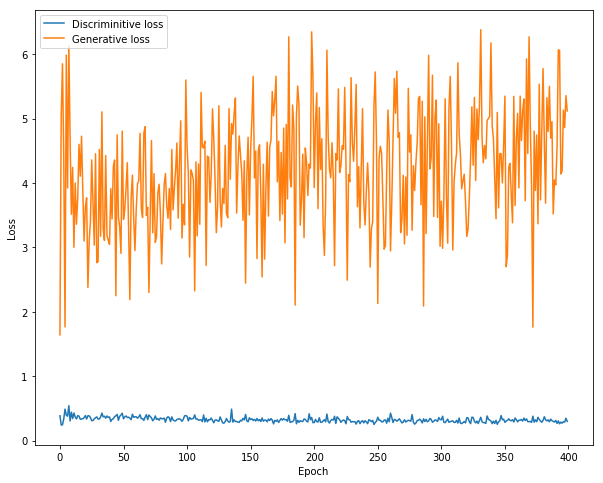

In [23]:
train(400, 128)

In [0]:
def plot_generated_images(generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()

Viewing GAN results. Running the below command each aand every time outputs different results.

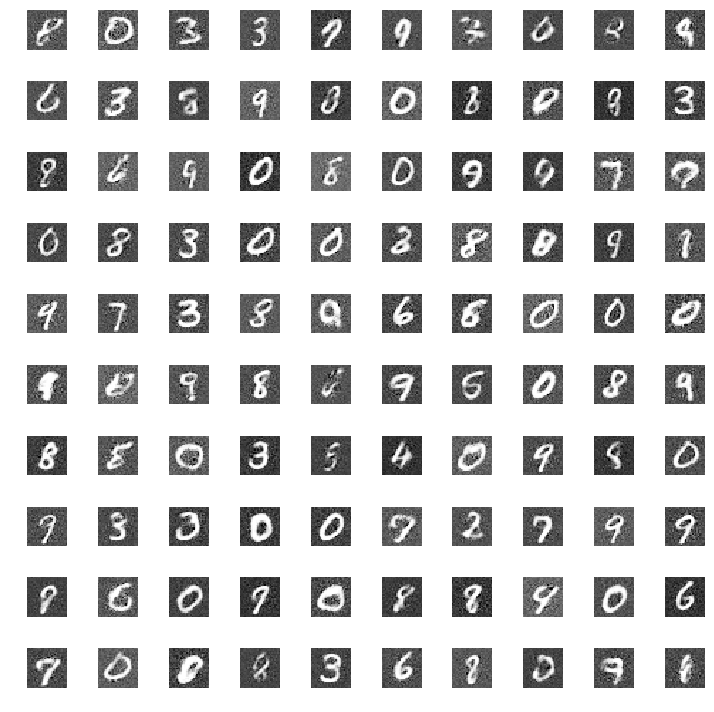

In [26]:
plot_generated_images(generator)

As we can see GAN was able to identify the patterns in the images and construct similar images to the digits from the MNIST.